In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('Resources/airlines_reviews.csv')

In [3]:
df.tail()

,Title,Name,Review Date,Airline,Verified,Reviews,Type of Traveller,Month Flown,Route,Class,Seat Comfort,Staff Service,Food & Beverages,Inflight Entertainment,Value For Money,Overall Rating,Recommended
8095,an uneventful flight,N Vickers,2016-06-20,Korean Air,True,"KE124, Brisbane to Incheon (A330) and KE867,...",Business,June 2016,BNE to ULN via ICN,Economy Class,5,4,5,3,4,7,yes
8096,Korean Air always impresses,Kim Holloway,2016-06-12,Korean Air,False,Our recent flight was our fourth trip to the...,Couple Leisure,June 2016,SYD to LHR via ICN,Economy Class,3,5,5,4,5,10,yes
8097,didn’t offer anything,C Clark,2016-06-06,Korean Air,True,I flew Korean Air from Bali to Seoul in Pres...,Business,April 2016,DPS to ICN,Business Class,4,5,5,5,1,2,no
8098,appreciated the service onboard,E Petan,2016-04-21,Korean Air,False,Seoul to Paris with Korean Air. I am traveli...,Business,April 2016,ICN to CDG,Business Class,5,1,3,4,5,10,yes
8099,genuinely friendly staff,D Lanor,2016-04-12,Korean Air,False,The 13 hour flight in Business class from Se...,Business,April 2016,ICN to YYZ,Business Class,3,5,3,3,5,10,yes


In [4]:
df.columns
df_updated = df['Title', 'Airline', 'Reviews',
       'Type of Traveller', 'Month Flown', 'Route', 'Class', 'Seat Comfort',
       'Staff Service', 'Food & Beverages', 'Inflight Entertainment',
       'Value For Money', 'Overall Rating', 'Recommended']]

Index(['Title', 'Name', 'Review Date', 'Airline', 'Verified', 'Reviews',
       'Type of Traveller', 'Month Flown', 'Route', 'Class', 'Seat Comfort',
       'Staff Service', 'Food & Beverages', 'Inflight Entertainment',
       'Value For Money', 'Overall Rating', 'Recommended'],
      dtype='object')

In [30]:
df['Staff Service'].value_counts()

Staff Service
5    3415
1    1414
4    1412
3    1061
2     798
Name: count, dtype: int64

In [6]:
df['Title']

0                         Flight was amazing
1       seats on this aircraft are dreadful 
2               Food was plentiful and tasty
3               “how much food was available
4            “service was consistently good”
                        ...                 
8095                    an uneventful flight
8096             Korean Air always impresses
8097                   didn’t offer anything
8098         appreciated the service onboard
8099                genuinely friendly staff
Name: Title, Length: 8100, dtype: object

In [7]:
df['Title'].value_counts()

Title
Turkish Airlines customer review    11
Qatar Airways customer review       11
worst customer service               9
a pleasant experience                9
seats were comfortable               8
                                    ..
very comfortable experience          1
not impressed by the performance     1
ANA is simply the best               1
bad communication                    1
genuinely friendly staff             1
Name: count, Length: 7614, dtype: int64

In [8]:
df['Route'].value_counts()

Route
Bangkok to Hong Kong                  24
London to Singapore                   23
Istanbul to London                    20
Bangkok to Singapore                  20
Hong Kong to Singapore                19
                                      ..
Amsterdam to Cebu via Dubai            1
Ho Chi Minh to Frankfurt via Dubai     1
Sydney to Moscow via Dubai             1
Brisbane to Madrid via Dubai           1
ICN to YYZ                             1
Name: count, Length: 5566, dtype: int64

In [9]:
df['Airline'].value_counts()

Airline
Turkish Airlines          1685
Qatar Airways             1624
Emirates                  1350
Singapore Airlines         972
Air France                 798
Cathay Pacific Airways     744
EVA Air                    281
All Nippon Airways         258
Japan Airlines             201
Korean Air                 187
Name: count, dtype: int64

In [10]:
# keep routes & split into Origin & Destination, find coord for the locations
# Target "Recommended"
# maybe user can provide the following and 
# Type of Traveller', 'Route', 'Class', 'Seat Comfort',
# 'Staff Service', 'Food & Beverages', 'Inflight Entertainment',
# 'Value For Money

In [11]:
from textblob import TextBlob
import csv 

In [33]:
with open('Resources/airlines_reviews.csv', 'r') as file:
    reader = csv.reader(file)
    # Skip the header row if it exists
    next(reader, None)

    # Iterate over the rows and extract the comments
    comments = [row[0] for row in reader]
    ratings = [row[15] for row in reader]

polarities = []
subjectivities = []

# Analyze the sentiment of each comment
for comment in comments:
    blob = TextBlob(comment)
    polarity = blob.sentiment.polarity
    subjectivity = blob.sentiment.subjectivity
    polarities.append(polarity)
    subjectivities.append(subjectivity)
    
    print(f"Comment: {comment}")
    print(f"Polarity: {polarity}")
    print(f"Subjectivity: {subjectivity}")
    print()

Comment: Flight was amazing
Polarity: 0.6000000000000001
Subjectivity: 0.9

Comment: seats on this aircraft are dreadful 
Polarity: -1.0
Subjectivity: 1.0

Comment: Food was plentiful and tasty
Polarity: 0.0
Subjectivity: 0.0

Comment: “how much food was available
Polarity: 0.30000000000000004
Subjectivity: 0.30000000000000004

Comment: “service was consistently good”
Polarity: 0.7
Subjectivity: 0.6000000000000001

Comment: “seat is absolutely dreadful”
Polarity: -1.0
Subjectivity: 1.0

Comment: Very ordinary service
Polarity: -0.325
Subjectivity: 0.65

Comment: I like flying this airline
Polarity: 0.0
Subjectivity: 0.0

Comment: left me deeply disappointed
Polarity: -0.375
Subjectivity: 0.375

Comment: can’t fault a single aspect 
Polarity: -0.07142857142857142
Subjectivity: 0.21428571428571427

Comment: No complaints at all
Polarity: 0.0
Subjectivity: 0.0

Comment: “I was impressed”
Polarity: 1.0
Subjectivity: 1.0

Comment: “Superb service”
Polarity: 1.0
Subjectivity: 1.0

Comment: r

In [34]:
#print(comments)
for c in comments:
    print(c)

Flight was amazing
seats on this aircraft are dreadful 
Food was plentiful and tasty
“how much food was available
“service was consistently good”
“seat is absolutely dreadful”
Very ordinary service
I like flying this airline
left me deeply disappointed
can’t fault a single aspect 
No complaints at all
“I was impressed”
“Superb service”
regional seat was really uncomfortable
“no problems whatsoever”
crew serving business disappeared
agent took out travel insurance on my behalf
one of the best flights
“received amazing support”
not fly with them in the future
Barely any room to move 
“outstanding service”
brilliant experience 
best alongside Qatar Airways 
allocated us three different seats
Deficient reservation system
swapping my itinerary to one day earlier
“flight delayed almost 4 hours”
I slept better than in economy
customer service is a nightmare
“No inflight entertainment at all”
easy, comfortable experience
“Above and beyond”
delayed 24 hours in September 2023
“they have not foll

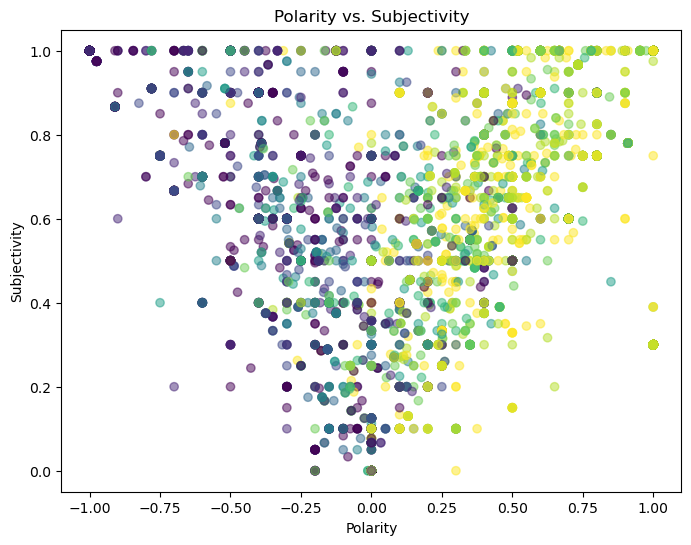

In [35]:
rate = df['Overall Rating']
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
scatter = plt.scatter(polarities, subjectivities, c=rate, cmap='viridis', alpha=0.5)
plt.xlabel('Polarity')
plt.ylabel('Subjectivity')
plt.title('Polarity vs. Subjectivity')
plt.show()

In [36]:
print(len(polarities))
print(len(subjectivities))
print(len(ratings))

8100
8100
0


In [ ]:
#trying something a bit different
#def Route_split (route):
 #   split_route = route.split()
  #  if len(route) > 1 and route[1][0].isupper():
   #     return route[0] + '' + route[1], route[2]
   # else:
    #    return route[0], route[2]

In [37]:
# **
def split_to_via(df, column):
    # Split the text based on separators (to, via)
    split_values = df[column].str.split(r'(?<=\bto\b)|(?<=\bvia\b)', expand=True)
    
    # remove to and via from the split columns
    split_values = split_values.apply(lambda x: x.str.replace(r'\bto\b|\bvia\b', '', regex=True))
    
    # Create new columns and load in the split values
    df['Origin'] = split_values[0].str.strip()
    df['Destination'] = split_values[1].str.split().str.join(' ').str.strip()
    df['Via'] = split_values[2].str.split().str.join(' ').str.strip()
    
    return df

In [38]:
#**

df_new = split_to_via(df, 'Route')

In [39]:
df_new.tail(20)

,Title,Name,Review Date,Airline,Verified,Reviews,Type of Traveller,Month Flown,Route,Class,Seat Comfort,Staff Service,Food & Beverages,Inflight Entertainment,Value For Money,Overall Rating,Recommended,Origin,Destination,Via
8080,standard flight with no frills,N Victor,2016-11-27,Korean Air,False,Flew Korean Air from Ulaanbaatar to Incheon....,Business,November 2016,ULN to ICN,Economy Class,4,5,3,5,3,7,yes,ULN,ICN,None
8081,arrive in Europe fresh and rested,Mark Devenish,2016-11-11,Korean Air,True,I recently travelled from Sydney to Prague (...,Solo Leisure,September 2016,SYD to PRG via ICN,Economy Class,4,4,4,5,5,10,yes,SYD,PRG,ICN
8082,staff were really helpful,W Dawe,2016-10-23,Korean Air,False,London Heathrow to Seoul Incheon. The staff ...,Solo Leisure,October 2016,LHR to ICN,Economy Class,2,1,5,1,5,10,yes,LHR,ICN,None
8083,counter service was horrible,S Vistaphon,2016-10-17,Korean Air,True,Washington to Seoul Incheon. The Korean Air ...,Solo Leisure,October 2016,IAD to ICN,Economy Class,2,5,5,3,2,3,no,IAD,ICN,None
8084,very good service,G Meira,2016-10-11,Korean Air,True,Flight from Sao Paulo (GRU) to Los Angeles wi...,Solo Leisure,September 2016,GRU to LAX,Business Class,1,5,5,4,3,6,yes,GRU,LAX,None
8085,the worst Asian airline,G Nazano,2016-09-21,Korean Air,True,New York JFK to Tashkent via Seoul Incheon. ...,Business,September 2016,JFK to TAS via ICN,Business Class,4,5,3,4,1,1,no,JFK,TAS,ICN
8086,I felt like a valued customer,V Anderson,2016-09-19,Korean Air,True,First time flying out of the country from Sa...,Solo Leisure,September 2016,SFO to ICN,Economy Class,4,5,4,4,5,10,yes,SFO,ICN,None
8087,had a positive experience,Samuel Higgs,2016-09-07,Korean Air,False,I had a positive experience on my recent fli...,Solo Leisure,September 2016,ICN to ORD,Economy Class,5,5,2,5,3,7,yes,ICN,ORD,None
8088,excellent customer service,Ray Labossiere,2016-08-11,Korean Air,False,\r\nVancouver to Cebu via Incheon with Korean...,Family Leisure,August 2016,YVR to CEB via ICN,Economy Class,5,5,3,4,5,10,yes,YVR,CEB,ICN
8089,helpful ground service staff,Samuel Tam,2016-08-03,Korean Air,False,Hong Kong to Seoul on Boeing 747-8I. General...,Family Leisure,July 2016,HKG to ICN,Economy Class,5,5,4,4,4,8,yes,HKG,ICN,None


In [ ]:
#df_new.head(25)
df_new['destination'].value_counts()

In [ ]:
origin = df['Destination'].value_counts()
print(origin)